In [1]:
import jax.numpy as jnp
import diffrax
import jax
jax.config.update('jax_enable_x64',True)
jax.config.update('jax_default_device',jax.devices()[2])

from jax.random import key
import matplotlib.pyplot as plt
import dill
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'serif'
savefig=False
save_path = "data.pkl"

In [2]:
n = 5
mu = -2.
gamma = 20.
omega = 0.25

delta_vals = 0. * jnp.ones(n)
alpha_vals = jax.random.uniform(key(12),(n,),minval = 2,maxval = 4)
beta_vals = 2 * jnp.ones(n)
all_args = jnp.vstack([delta_vals,alpha_vals,beta_vals]).T

def duffing_term(t,x,args):
    delta,alpha,beta = args
    xdot = jnp.array(
		[
            x[1],
            -delta * x[1] - alpha * x[0] - beta * x[0]**3
		]
	)
    return xdot


duffing_damp = jax.vmap(duffing_term,in_axes=(None,0,0))

K = jnp.zeros(n)
K = jnp.diag(jnp.ones(n-1),1)
K = K + jnp.diag(jnp.ones(n-1),-1)
K = K.at[(0,n-1),(n-1,0)].set(1.)

K = K - jnp.diag(jnp.sum(K,axis=0))

In [3]:
initial_conditions = jnp.vstack([jnp.linspace(-2,2,n),jnp.zeros(n)]).T

initial_conditions = jnp.vstack([
    jax.random.normal(key(23),n),
    jax.random.normal(key(133),n)
    ]).T

initial_conditions = jnp.vstack([jnp.ones(n),jnp.zeros(n)]).T

def linear_coupling(x):
    states = x[:,0]
    coupling_term = K@states
    full_term = mu * jnp.hstack([jnp.zeros((n,1)),coupling_term[:,None]])
    return full_term

def ode_f(t,x,args):
    return duffing_damp(t,x,args) + linear_coupling(x)# + gamma * jnp.array([0,jnp.cos(omega*t)])


dt0 = 0.0025
T = 50.
stepsize_controller = diffrax.PIDController(rtol = 1e-8,atol =1e-8)
save_at = diffrax.SaveAt(dense=True)
sol = diffrax.diffeqsolve(
	terms = diffrax.ODETerm(ode_f),
	solver = diffrax.Tsit5(),
	t0=0.,
	t1=T,
	dt0=dt0,
	y0=initial_conditions,
	saveat=save_at,
    stepsize_controller=stepsize_controller,
    max_steps = int(20 * (T/dt0)),
    args = all_args
)

In [4]:
T_train = 30
t_grid = jnp.linspace(0,T_train,500)
values = jax.vmap(lambda t:sol.evaluate(t)[:,0])(t_grid)
# for col in values.T:
#     plt.plot(t_grid,col)

In [5]:
dt = 0.2
t_train = jnp.arange(0,T_train,dt)
x_vals = jax.vmap(lambda t:sol.evaluate(t)[:,0])(t_train)
noise_sigma = 0.2
x_train = x_vals + noise_sigma*jax.random.normal(key(31),x_vals.shape)


In [6]:
from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant,CholDataAdaptedRKHSInterpolant,CholRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel,PolyLib
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ,SSR,MIOSR,PolynomialLibrary

polylib = PolyLib(degree = 3,include_interaction=False)

trajectory_model = CholDataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.,feature_map=polylib)
optsettings = LMSettings(
    max_iter = 1000,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
    print_every = 100,
)
data_weight =  1.
n_colloc = 500
colloc_weight = 1e5#50. * n_colloc * 
sparsifier = pySindySparsifier(
    STLSQ(threshold = 0.1,alpha = 0.01)
    )

# sparsifier = pySindySparsifier(
#     MIOSR(target_sparsity = 7,alpha = 0.1)
#     )


optimizer = AlternatingActiveSetLMSolver(
        beta_reg=1e-3,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=['x0','x1','x2','x3','x4'],
    input_orders = (0,1),
    ode_order = 2
)

/home/grisal/github/jsindy/.venv/lib/python3.12/site-packages/sympy2jax/sympy_module.py:291: UserWarning: `equinox.static_field` is deprecated in favour of `equinox.field(static=True)`
  has_extra_funcs: bool = eqx.static_field()


# Only run if data hasn't been saved

In [7]:
model.fit(
    t_train,
    x_train,
)
model.print()


{'show_progress': True, 'sigma2_est': Array(0.03705482, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 100000.0}
Warm Start


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 2.085e+06, gradnorm = 1.196e+07, alpha = 4.167, improvement_ratio = 0.8338
Iteration 1, loss = 1.415e+05, gradnorm = 1.796e+07, alpha = 3.472, improvement_ratio = 0.9321
Iteration 2, loss = 4.033e+03, gradnorm = 5.014e+06, alpha = 2.894, improvement_ratio = 0.9717
Iteration 3, loss = 535.1, gradnorm = 9.355e+05, alpha = 2.411, improvement_ratio = 0.8718
Iteration 4, loss = 246.9, gradnorm = 5.048e+05, alpha = 2.411, improvement_ratio = 0.5584
Iteration 5, loss = 84.54, gradnorm = 2.999e+05, alpha = 2.411, improvement_ratio = 0.7091
Iteration 100, loss = 11.31, gradnorm = 620.0, alpha = 0.3894, improvement_ratio = 0.7899
Iteration 200, loss = 11.17, gradnorm = 94.41, alpha = 0.05241, improvement_ratio = 0.7404
Iteration 290, loss = 11.17, gradnorm = 0.0001065, alpha = 0.05734, improvement_ratio = 356.8
Model after smooth warm start
(x0)'' = -0.036 1 + 0.443 x0 + -2.621 x1 + 0.490 x2 + 0.084 x3 + -1.314 x4 + -0.112 (x0') + -0.072 (x1') + -0.025 (x2') + -0.033 (x3') + 

In [16]:
true_theta = jnp.vstack(
    [
        jnp.zeros((1,n)),
        -jnp.diag(alpha_vals)+mu*K,
        jnp.zeros((3*n,n)),
        jnp.diag(-beta_vals),
        jnp.zeros((n,n))
	]
)

In [17]:
# jnp.max(true_theta - model.theta)

In [18]:
sol.evaluate(30.)
def model_ode(t,x,args=None):
	return jnp.vstack([x[:,1],model.predict(x.T.flatten())]).T
dt0 = 0.0025
T = 30.
stepsize_controller = diffrax.PIDController(rtol = 1e-8,atol =1e-8)
save_at = diffrax.SaveAt(dense=True)
model_sol = diffrax.diffeqsolve(
	terms = diffrax.ODETerm(model_ode),
	solver = diffrax.Tsit5(),
	t0=0.,
	t1=T,
	dt0=dt0,
	y0=initial_conditions,
	saveat=save_at,
    stepsize_controller=stepsize_controller,
    max_steps = int(20 * (T/dt0)),
)


In [11]:
# state_preds = model.predict_state(t_train)
# integrated_model = jax.vmap(lambda t:model_sol.evaluate(t)[:,0])(t_train)
# for i in range(n):
#     plt.figure(figsize=(12,3))
#     plt.scatter(t_train,x_train[:,i],edgecolors = 'red',c = 'black')
#     plt.plot(t_train,state_preds[:,i],c='red',lw = 5,alpha = 0.5)
#     plt.plot(t_train,x_vals[:,i],c='black')
#     plt.plot(t_train,integrated_model[:,i],c='blue',alpha = 0.5,lw = 5)
#     plt.show()

In [19]:
def model_ode(t,x,args=None):
	return jnp.vstack([x[:,1],model.predict(x.T.flatten())]).T
dt0 = 0.0025
stepsize_controller = diffrax.PIDController(rtol = 1e-8,atol =1e-8)
save_at = diffrax.SaveAt(dense=True)
model_sol = diffrax.diffeqsolve(
	terms = diffrax.ODETerm(model_ode),
	solver = diffrax.Tsit5(),
	t0=30.,
	t1=50,
	dt0=dt0,
	y0=sol.evaluate(30.),
	saveat=save_at,
    stepsize_controller=stepsize_controller,
    max_steps = int(20 * (T/dt0)),
)


In [20]:
t_fine = jnp.linspace(0.,30,1000)
x_true = jax.vmap(lambda t:sol.evaluate(t)[:,0])(t_fine)
x_pred = model.predict_state(t_fine)

t_extend = jnp.linspace(t_train[-1],50,500)

x_true_extend = jax.vmap(lambda t:sol.evaluate(t)[:,0])(t_extend)
x_sim_extend = jax.vmap(lambda t:model_sol.evaluate(t)[:,0])(t_extend)

## save data

In [21]:
data = {
    "t_true": t_fine,
    "x_true": x_true,
    "x_pred": x_pred,
    "t_train": t_train,
    "x_train": x_train,
    "t_extend": t_extend,
    "x_true_extend": x_true_extend,
    "x_sim_extend":x_sim_extend,
    "true_theta":true_theta,
    "model": model
}

# _ = data.pop("model")

with open(save_path,'wb') as file:
    dill.dump(data,file)

In [22]:
import os 
os.path.getsize(save_path)/1e6

600.579781

# Load Data/Model

In [2]:
with open(save_path, 'rb') as file:
    data = dill.load(file)

t_fine = data["t_true"]
x_true = data["x_true"]
x_pred = data["x_pred"]

t_train = data["t_train"]
x_train = data["x_train"]

t_extend = data["t_extend"]
x_true_extend = data["x_true_extend"]
x_sim_extend = data["x_sim_extend"]
true_theta = data["true_theta"]

model = data["model"]

/home/grisal/github/jsindy/.venv/lib/python3.12/site-packages/sympy2jax/sympy_module.py:291: UserWarning: `equinox.static_field` is deprecated in favour of `equinox.field(static=True)`
  has_extra_funcs: bool = eqx.static_field()


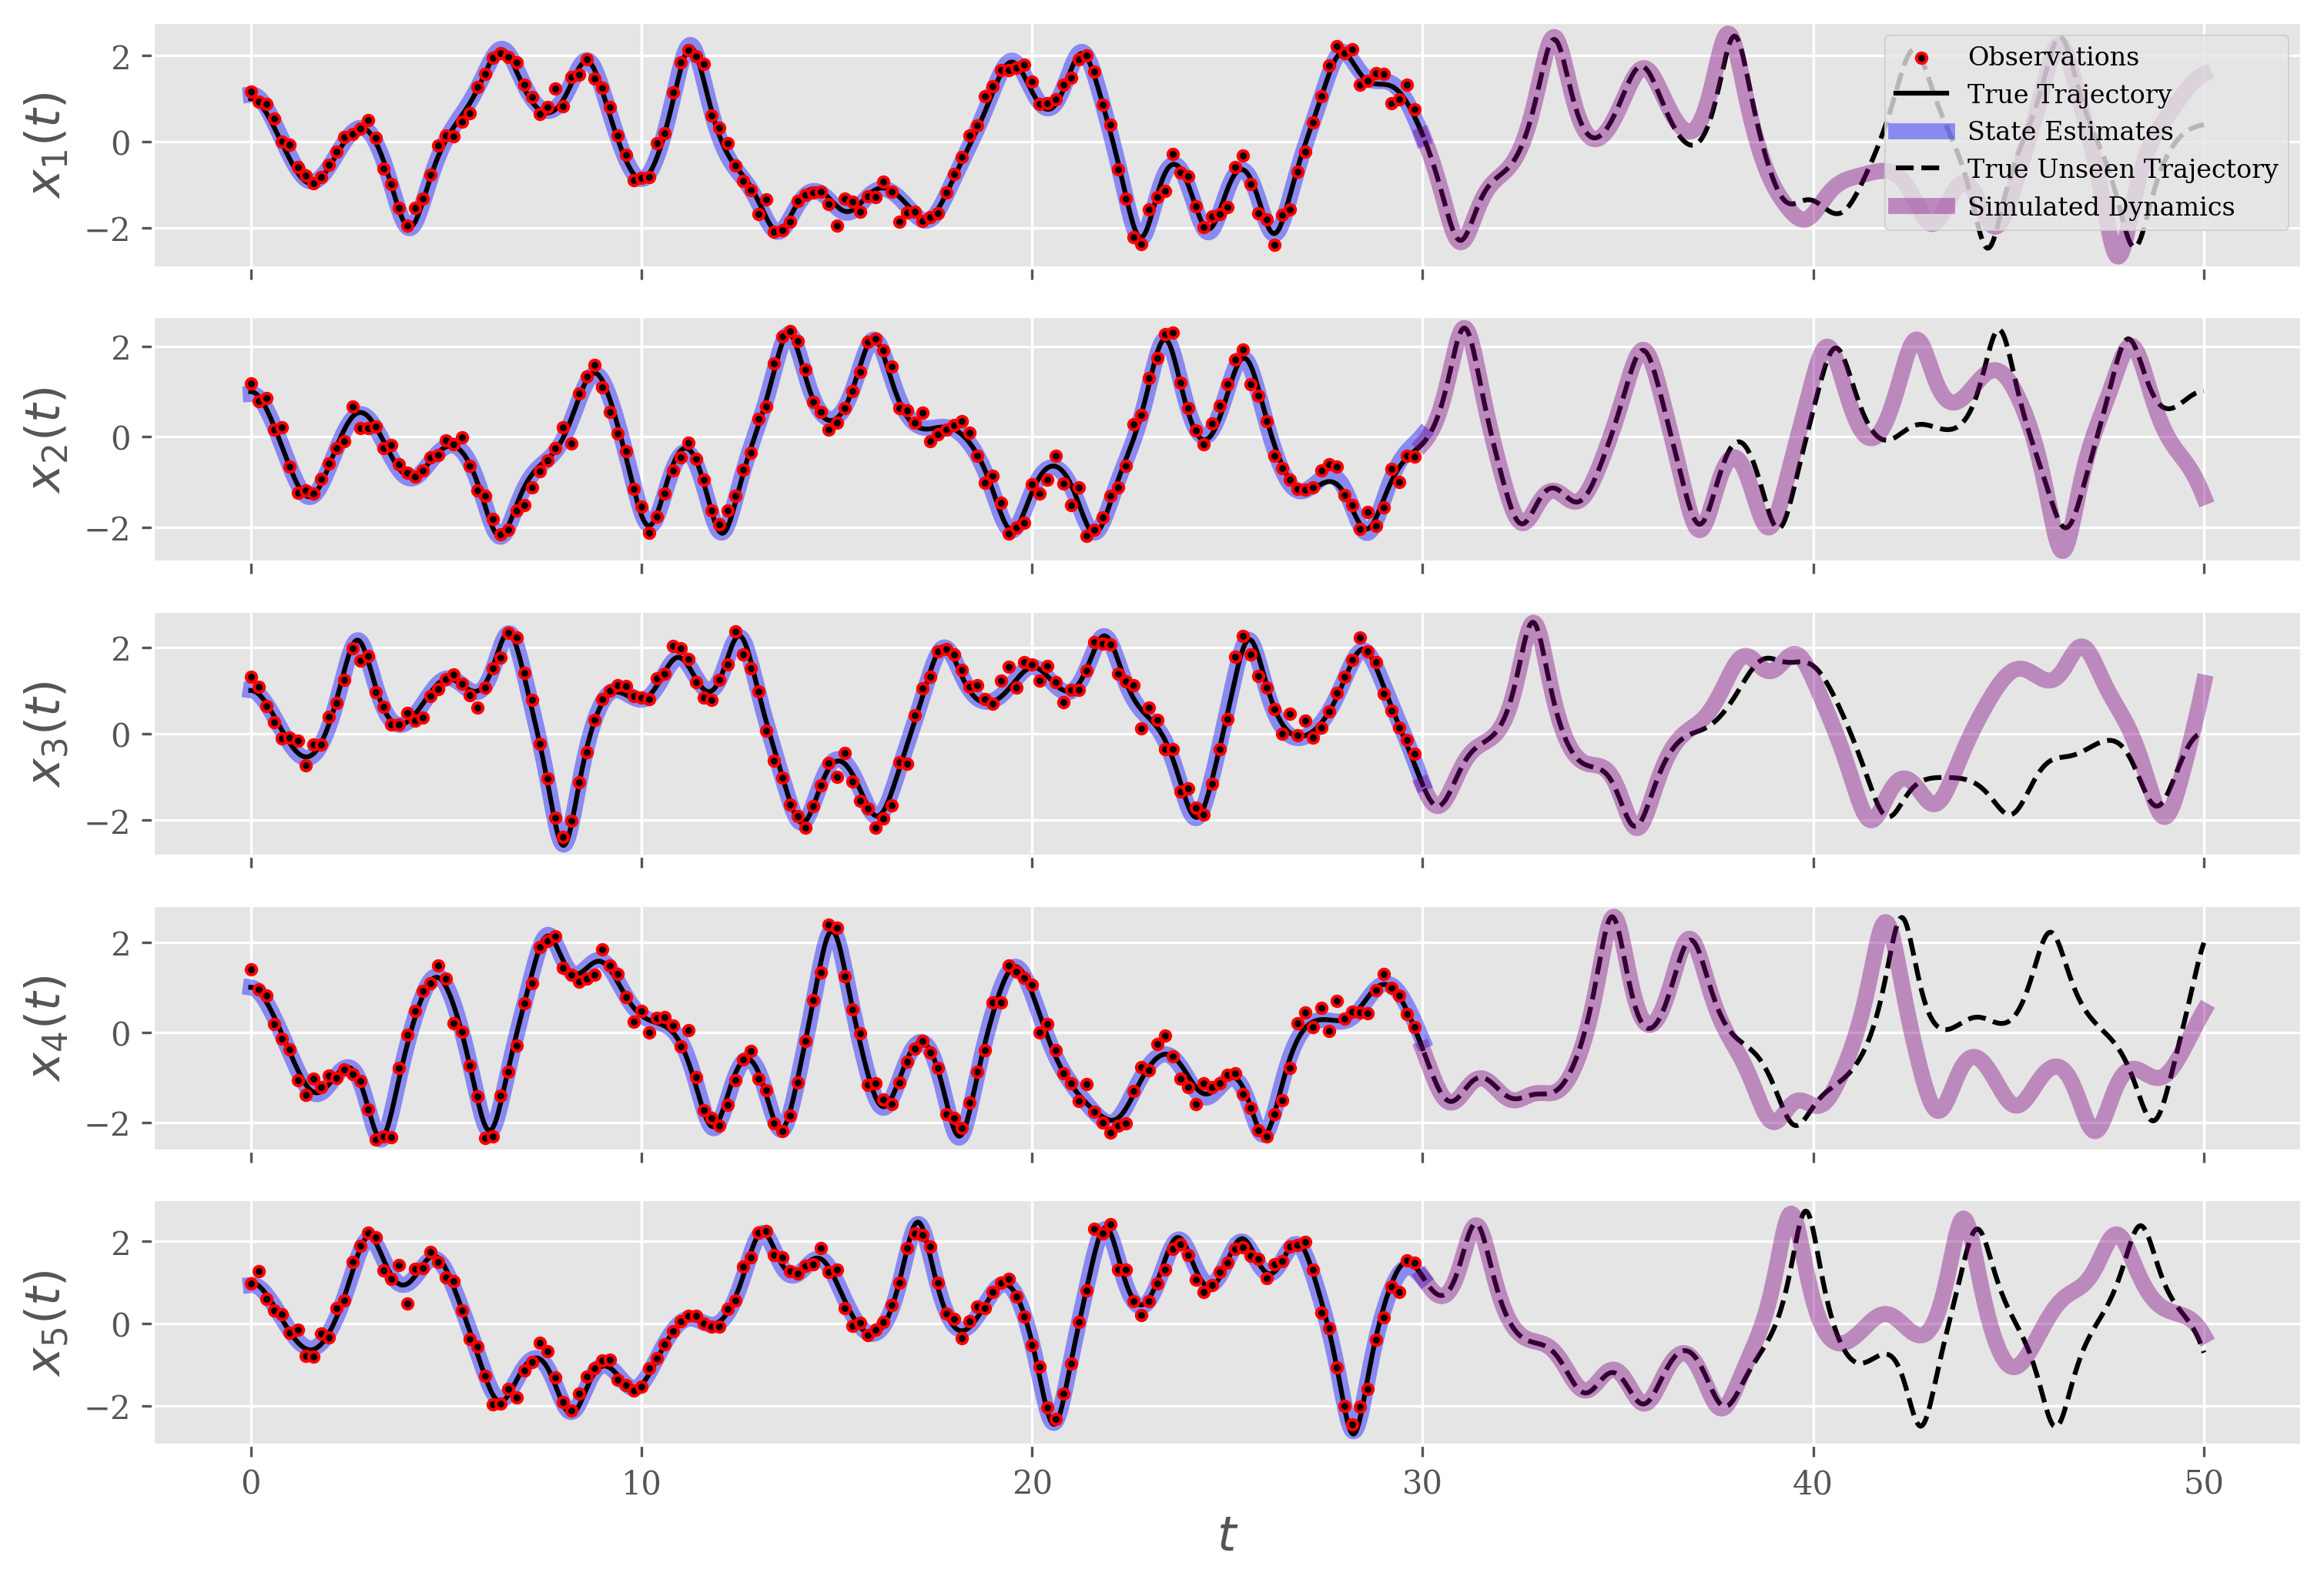

In [3]:
family='serif'
num_dims = len(x_true.T)
fig, ax = plt.subplots(num_dims,1, figsize=(12,8),sharex=True,dpi=300)
ylabels = [r"$x_1(t)$", r"$x_2(t)$",r"$x_3(t)$",r"$x_4(t)$",r"$x_5(t)$"]


for dim in range(num_dims):
    ax[dim].scatter(t_train,x_train[:,dim]
                    ,facecolors='black',edgecolors='red',lw=1, label='Observations',s=10,zorder=3) 
    ax[dim].plot(t_fine, x_true[:,dim], label='True Trajectory',c='black',zorder=2)
    ax[dim].plot(t_fine, x_pred[:,dim], label='State Estimates', linestyle='-',c='blue', alpha=0.4,lw=5,zorder=1)

    # extension 
    ax[dim].plot(t_extend,x_true_extend[:,dim], c='black', linestyle='--', label='True Unseen Trajectory')    

    ax[dim].plot(t_extend,x_sim_extend[:,dim],c='purple',alpha=0.4, lw=5,linestyle='-',label='Simulated Dynamics')

    ax[dim].grid(True)
    ax[dim].set_ylabel(ylabels[dim], size=15, family=family)
    if dim==0:
        ax[dim].legend(prop={'family':family,'size':8},loc='upper right')
    if dim == 4:
        ax[dim].set_xlabel(r"$t$",size=15, family=family)
# plt.suptitle("Coupled Duffing System", family=family,size=20)

# plt.savefig(f"coupled_duffing.pdf")
plt.show()


# Metrics

In [4]:
mse = jnp.mean((x_true - x_pred)**2,axis=0)/jnp.var(x_true,axis=0)
mae_coeff = jnp.sum(jnp.abs(true_theta - model.theta)) / jnp.sum(jnp.abs(true_theta))
# start_time = 6
# mse_sim = jnp.mean((x_true_extend[start_time:,:] - x_sim_extend[start_time:,:])**2,axis=0)/jnp.var(x_true_extend[start_time:,:],axis=0)

In [7]:
print(f"{jnp.mean(mse).item():.3e}")
print(f"{mae_coeff:.3e}")

1.263e-03
3.066e-02


# Other plots

In [9]:
n = 5
mu = -2.
gamma = 20.
omega = 0.25
noise_sigma = 0.2

delta_vals = 0. * jnp.ones(n)
alpha_vals = jax.random.uniform(key(12),(n,),minval = 2,maxval = 4)
beta_vals = 2 * jnp.ones(n)
all_args = jnp.vstack([delta_vals,alpha_vals,beta_vals]).T

def duffing_term(t,x,args):
    delta,alpha,beta = args
    xdot = jnp.array(
		[
            x[1],
            -delta * x[1] - alpha * x[0] - beta * x[0]**3
		]
	)
    return xdot


duffing_damp = jax.vmap(duffing_term,in_axes=(None,0,0))

K = jnp.zeros(n)
K = jnp.diag(jnp.ones(n-1),1)
K = K + jnp.diag(jnp.ones(n-1),-1)
K = K.at[(0,n-1),(n-1,0)].set(1.)

K = K - jnp.diag(jnp.sum(K,axis=0))


initial_conditions = jnp.vstack([jnp.ones(n),jnp.zeros(n)]).T

def linear_coupling(x):
    states = x[:,0]
    coupling_term = K@states
    full_term = mu * jnp.hstack([jnp.zeros((n,1)),coupling_term[:,None]])
    return full_term

def ode_f(t,x,args):
    return duffing_damp(t,x,args) + linear_coupling(x)# + gamma * jnp.array([0,jnp.cos(omega*t)])


dt0 = 0.0025
T = 50.
stepsize_controller = diffrax.PIDController(rtol = 1e-8,atol =1e-8)
save_at = diffrax.SaveAt(dense=True)
sol = diffrax.diffeqsolve(
	terms = diffrax.ODETerm(ode_f),
	solver = diffrax.Tsit5(),
	t0=0.,
	t1=T,
	dt0=dt0,
	y0=initial_conditions,
	saveat=save_at,
    stepsize_controller=stepsize_controller,
    max_steps = int(20 * (T/dt0)),
    args = all_args
)

def model_ode(t,x,args=None):
	return jnp.vstack([x[:,1],model.predict(x.T.flatten())]).T
dt0 = 0.0025
stepsize_controller = diffrax.PIDController(rtol = 1e-8,atol =1e-8)
save_at = diffrax.SaveAt(dense=True)
model_sol = diffrax.diffeqsolve(
	terms = diffrax.ODETerm(model_ode),
	solver = diffrax.Tsit5(),
	t0=30.,
	t1=50,
	dt0=dt0,
	y0=sol.evaluate(30.),
	saveat=save_at,
    stepsize_controller=stepsize_controller,
    max_steps = int(20 * (T/dt0)),
)

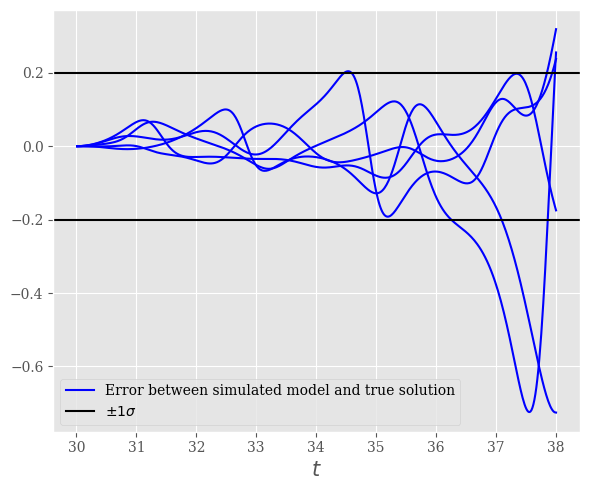

In [10]:
plt.figure(figsize=(6,5))
t_extend = jnp.linspace(t_train[-1],38,500)

x_true_extend = jax.vmap(lambda t:sol.evaluate(t)[:,0])(t_extend)
x_sim_extend = jax.vmap(lambda t:model_sol.evaluate(t)[:,0])(t_extend)

for dim in range(5):
	if dim ==0:
		plt.plot(t_extend,x_true_extend[:,dim]-x_sim_extend[:,dim],c='blue',label = "Error between simulated model and true solution")
	else:
		plt.plot(t_extend,x_true_extend[:,dim]-x_sim_extend[:,dim],c='blue')
plt.axhline(noise_sigma,c='black',label = r"$\pm 1 \sigma$")
plt.axhline(-noise_sigma,c='black')
plt.xlabel(r'$t$',size=15)
plt.legend(loc = 'lower left')
plt.tight_layout()
# plt.savefig("cduff_pred_error.pdf")

In [11]:
true_xdot = jax.vmap(lambda t:sol.evaluate(t)[:,1])(t_fine)
true_xddot = jax.vmap(lambda t:ode_f(t,sol.evaluate(t),all_args)[:,1])(t_fine)
pred_xdot = model.traj_model.derivative(t_fine,model.z,1)
pred_xddot = model.traj_model.derivative(t_fine,model.z,2)

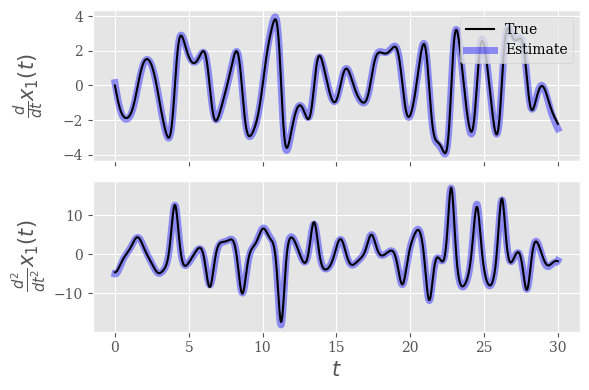

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

dim = 0
axs[0].plot(t_fine, true_xdot[:, dim], label=r'True',
            c='black', zorder=2)
axs[0].plot(t_fine, pred_xdot[:, dim], label=r'Estimate',
            linestyle='-', c='blue', alpha=0.4, lw=5, zorder=1)
axs[0].legend(loc='upper right')
axs[0].set_ylabel(r"$\frac{d}{dt}$"+ rf"$x_{dim+1}(t)$", rotation=90, labelpad=12,size=15)

axs[1].plot(t_fine, true_xddot[:, dim], label=r'$\frac{d^2}{dt^2}x_0(t)$',
            c='black', zorder=2)
axs[1].plot(t_fine, pred_xddot[:, dim], label=r'Estimated $\frac{d^2}{dt^2}x_0(t)$',
            linestyle='-', c='blue', alpha=0.4, lw=5, zorder=1)
# axs[1].legend(loc='upper right')
axs[1].set_xlabel(r"$t$",size=15)
axs[1].set_ylabel(r"$\frac{d^2}{dt^2}$" + rf"$x_{dim+1}(t)$", rotation=90, labelpad=None,size=15)

plt.tight_layout()
# plt.savefig("cduff_deriv_estimates.pdf")


In [35]:
# true_xdot

In [13]:
true_xdot = jax.vmap(lambda t:sol.evaluate(t)[:,1])(t_fine)

true_xdot2 = jax.vmap(jax.jacfwd(lambda t:sol.evaluate(t)[:,1]))(t_fine)

true_xdot3 = jax.vmap(jax.jacfwd(jax.jacfwd(lambda t:sol.evaluate(t)[:,1])))(t_fine)

true_xdot4 = jax.vmap(jax.jacfwd(jax.jacfwd(jax.jacfwd(lambda t:sol.evaluate(t)[:,1]))))(t_fine)

true_xdots = [
    true_xdot,
    true_xdot2,
    true_xdot3,
    true_xdot4,
]


In [14]:
pred_xdots = []
for i in range(1,5):
    pred_xdots.append(
        model.traj_model.derivative(t_fine,model.z,i)
    )
# pred_xdot = model.traj_model.derivative(t_fine,model.z,1)
# pred_xddot = model.traj_model.derivative(t_fine,model.z,2)
# pred_xdddot = model.traj_model.derivative(t_fine,model.z,3)
# pred_xddddot = model.traj_model.derivative(t_fine,model.z,4)

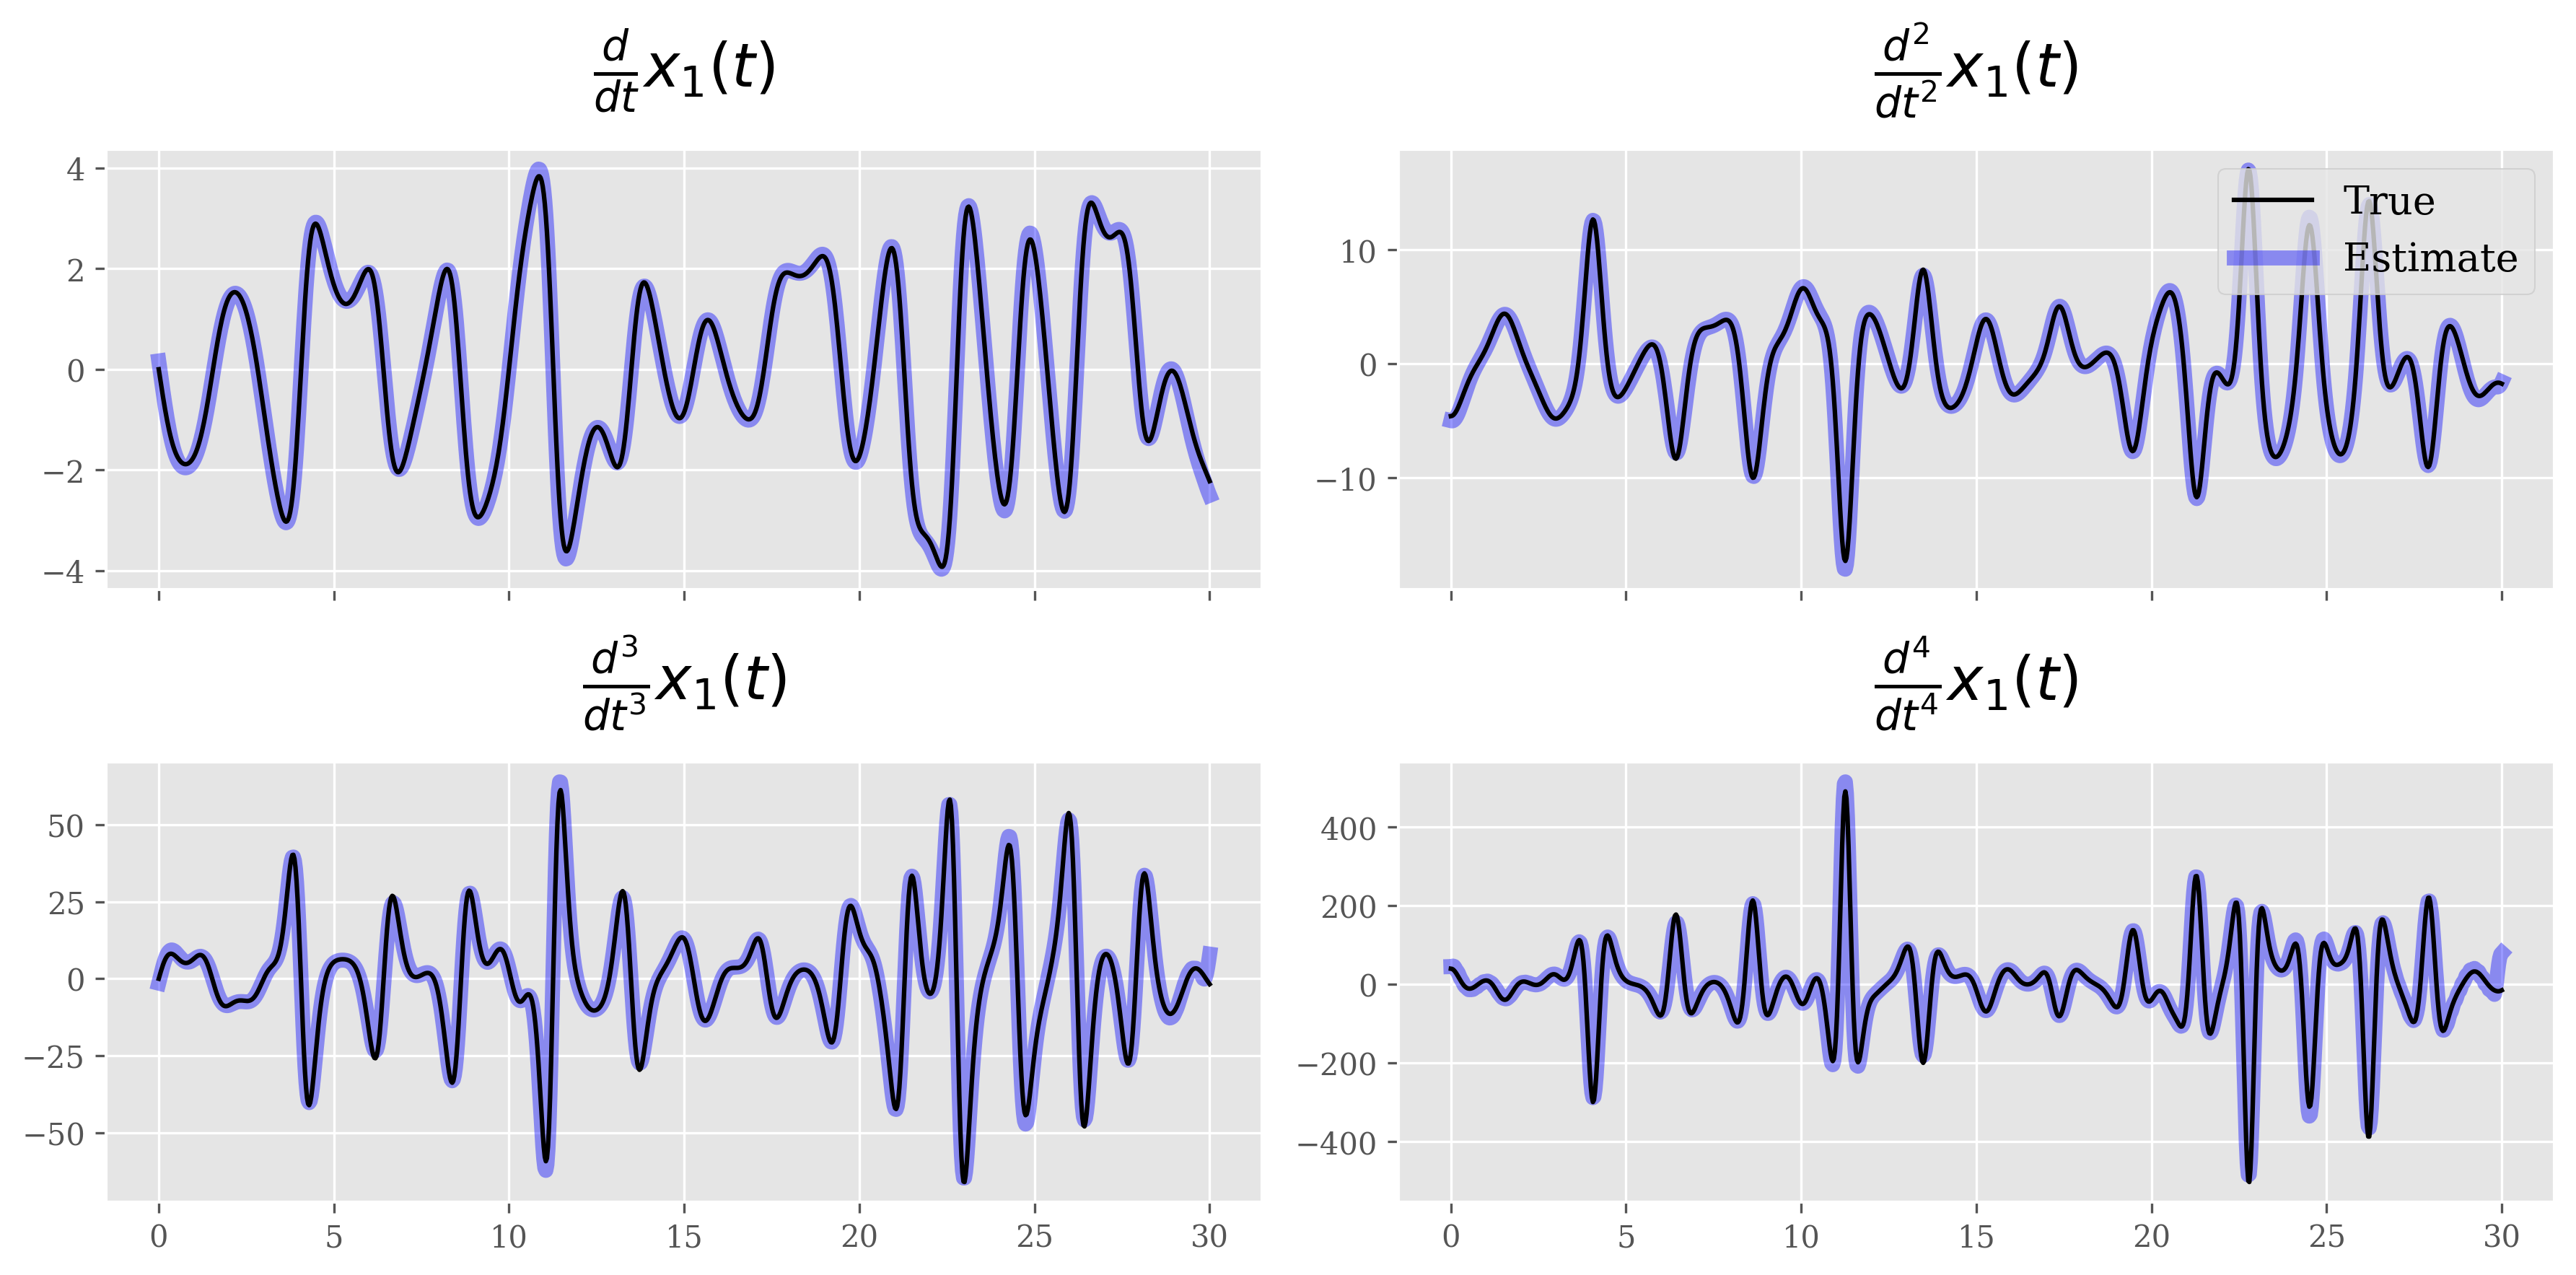

In [15]:
dim = 0


y_labels = [
    r"$\frac{d}{dt}$" + rf"$x_{dim+1}(t)$",
    r"$\frac{d^2}{dt^2}$" + rf"$x_{dim+1}(t)$",
    r"$\frac{d^3}{dt^3}$" + rf"$x_{dim+1}(t)$",
    r"$\frac{d^4}{dt^4}$" + rf"$x_{dim+1}(t)$"
]

fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharex=True,dpi=300)

axs = axs.flatten()
for idx, ax in enumerate(axs):
    true = true_xdots[idx]
    pred = pred_xdots[idx]
    true_lab = None
    pred_lab = None

    if idx == 1:
        true_lab = 'True'
        pred_lab = "Estimate"

    ax.plot(t_fine,true[:,dim],label=true_lab,c='black',zorder=2)
    ax.plot(t_fine, pred[:,dim],label=pred_lab, linestyle='-',c='blue',alpha=0.4,lw=5,zorder=1)

    # ax.plot(t_fine,true[:,dim+1],label=true_lab,c='black',zorder=2)
    # ax.plot(t_fine, pred[:,dim+1],label=pred_lab, linestyle='-',c='blue',alpha=0.4,lw=5,zorder=1)

    ax.set_title(y_labels[idx],size=20,y=1.1)
    if idx ==1:
        ax.legend(loc='upper right',prop={'size':13})
        
plt.tight_layout()
# plt.savefig("4_derivs.pdf")
plt.show()

# Metrics

In [16]:
for true_i, pred_i in zip(true_xdots, pred_xdots):
    mse = jnp.mean((true_i - pred_i)**2,axis=0)/jnp.var(true_i,axis=0)
    print(mse,jnp.mean(mse))

[0.00137916 0.00421771 0.00184778 0.0018666  0.00228596] 0.0023194421487099655
[0.00193439 0.00615352 0.00365746 0.00332869 0.00333643] 0.0036820986084760256
[0.00357558 0.01119797 0.00639862 0.00603782 0.0056151 ] 0.006565016586560378
[0.00826108 0.01982494 0.00971484 0.00899812 0.00841845] 0.011043487139330706
